# Phylogenetic trees and Data remapping

In [1]:
from scipy import signal
import numpy as np
import pandas as pd
import bisect
import importlib
import warnings
from pathlib import Path
import gc
import os

import ete3
np.random.seed(7)

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

#import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Monospace font for numbers in tables:

In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

## Data dir

In [4]:
data_path = Path('/project/Birds/faststorage/data')
results_path = Path('/project/Birds/faststorage/people/kmt/bird-hotspots/results')
figures_path = Path('/project/Birds/faststorage/people/kmt/bird-hotspots/figures')

## Branch lenghts

UPGMA code:

In [5]:
def find_lowest_cell(table):
    x = 1
    y = 0
    min_val = table[x][y]
    for i in range(len(table)):
        for j in range(len(table[i])):
            if table[i][j] < min_val:
                min_val = table[i][j]
                x = i
                y = j
    return [x, y]

def link(x, y, wx, wy):
    return (x * wx + y * wy) / (wx + wy)

def update_table(table, a, b, weight_a, weight_b):
    for i in range(0, b):
        table[b][i] = link(table[b][i], table[a][i], weight_b, weight_a)
    for j in range(b+1, a):
        table[j][b] = link(table[j][b], table[a][j], weight_b, weight_a)
    for i in range(a+1, len(table)):
        table[i][b] = link(table[i][b], table[i][a], weight_b, weight_a)
    for i in range(a+1, len(table)):
        del table[i][a]
    del table[a] 

def update_labels(labels, i, j, di, dj):
    labels[j] = "({}:{},{}:{})".format(labels[j], dj, labels[i], di)
    del labels[i]

def upgma(mat, names):

    table = mat[:]
    labels = names[:]
    node_heights = [0 for _ in labels]

    while len(labels) > 1:
        i, j = find_lowest_cell(table)
        
        dist = table[i][j]

        wi = max(1, labels[i].count(':'))
        wj = max(1, labels[j].count(':'))

        new_node_height = dist / 2
        di = new_node_height - node_heights[i]
        dj = new_node_height - node_heights[j]
        
        update_table(table, i, j, wi, wj)
        update_labels(labels, i, j, di, dj)
        node_heights[j] = new_node_height
        del node_heights[i]
        
    return labels[0] + ';'

Tree plotting code:

In [6]:
def plot_tree(t, ax, leaf_colors=None, show_inner_nodes=False, fontsize=10, 
              text_offset=None, margins=(0.5, 1, 0.5, 1), align_labels=False): # top, right, bottom, left

    y_offset = len(t.get_leaves())
    for node in t.traverse("preorder"):
        node.x_offset = node.dist + sum(x.dist for x in node.get_ancestors())
        if node.is_leaf():
            y_offset -= 1
            node.y_offset = y_offset

    for node in t.traverse("postorder"):
        if not node.is_leaf():
            node.y_offset = sum(x.y_offset for x in node.children) / len(node.children)

    horizontal_lines = list()
    vertical_lines = list()
    node_coords = list()
    leaf_coords = list()
    max_x_offset = 0
    for node in t.traverse("postorder"):
        max_x_offset = max(max_x_offset, node.x_offset)
        node_coords.append((node.x_offset, node.y_offset))
        if node.is_leaf():
            leaf_coords.append([node.name, node.x_offset, node.y_offset])
        if not node.is_root():
            y = node.y_offset
            horizontal_lines.append(([node.up.x_offset, node.x_offset], [y, y]))
        if not node.is_leaf():
            c = sorted(node.children, key=lambda x: x.y_offset)
            bottom, top = c[0], c[-1]
            x = node.x_offset
            vertical_lines.append(([x, x],[bottom.y_offset, top.y_offset]))

    
    # shift the tree to put leaves at zero
    for i in range(len(horizontal_lines)):
        horizontal_lines[i][0][0] -= max_x_offset
        horizontal_lines[i][0][1] -= max_x_offset
    for i in range(len(vertical_lines)):
        vertical_lines[i][0][0] -= max_x_offset
        vertical_lines[i][0][1] -= max_x_offset
    for i in range(len(leaf_coords)):
        leaf_coords[i][1] -= max_x_offset
            
    # draw the tree:
    for x in horizontal_lines:
        ax.plot(*x, c='black', linewidth=0.8)
    for x in vertical_lines:
        ax.plot(*x, c='black', linewidth=0.8)

#     for tup in node_coords:
#         ax.plot(*tup, c='black', marker="o")

    if text_offset is None:
        text_offset = max_x_offset / 20
        
    for name, x, y in leaf_coords:
        
        name = name.split('_', 1)[1].replace('_', ' ').capitalize()

        
        if align_labels:
            ax.text(0+text_offset, y, name, fontsize=fontsize, backgroundcolor='white',
                    verticalalignment='center', horizontalalignment='left')
            if leaf_colors is None:
                color = 'black'
            else:
                color = leaf_colors[name]
            ax.plot(x, y, c=color, marker="o", ms=3)

            ax.add_line(Line2D((x, margins[1]), (y, y), linewidth=0.8, color='grey', linestyle='dashed', zorder=0))
        else:
            ax.text(x+text_offset, y, name, fontsize=fontsize, backgroundcolor='white',
                    verticalalignment='center', horizontalalignment='left')
            if leaf_colors is None:
                color = 'black'
            else:
                color = leaf_colors[name]
            ax.plot(x, y, c=color, marker="o", ms=3)


#     ax.set_xlim(-margins[3], max_x_offset + margins[1])
    ax.set_xlim(-margins[3]-max_x_offset, margins[1])
    ax.set_ylim(-margins[2], len(leaf_coords)-1+margins[0])


    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['right'].set_visible(False)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax.set_xlim(right=max_x_offset/20)
    
    return leaf_coords


def make_comb_tree(t):
    for node in t.traverse():
        if not node.is_leaf():
            node.children = sorted(node.children, key=lambda c: len(c.get_leaves()), reverse=False)
    

Read in tree make ultrametric version:

In [7]:
with open(data_path / 'tree_ancestors_species2014_english.txt') as f:
    s = f.read().strip()
tree = ete3.Tree(s, format=1)

Remove white tailed eagle with a very short external branch. This is to also use the the much longer branch anestral to both eagles:

In [8]:
tree.prune([x for x in tree.get_leaves() if x.name != 'HALAL_white-tailed_eagle'], preserve_branch_length=True)
#print(str(tree))

Make a UPGMA tree:

In [9]:
name_list = tree.get_leaf_names()
lowtri = list()
for i in range(len(name_list)):
    lowtri.append([])
    for j in range(i):
        lowtri[i].append((tree&name_list[i]).get_distance(name_list[j]))
        
upgma_tree = ete3.Tree(upgma(lowtri, name_list), format=1)

TENT tree made ultrametric:

In [10]:
ultrametric_tree = tree.copy()
ultrametric_tree.convert_to_ultrametric()

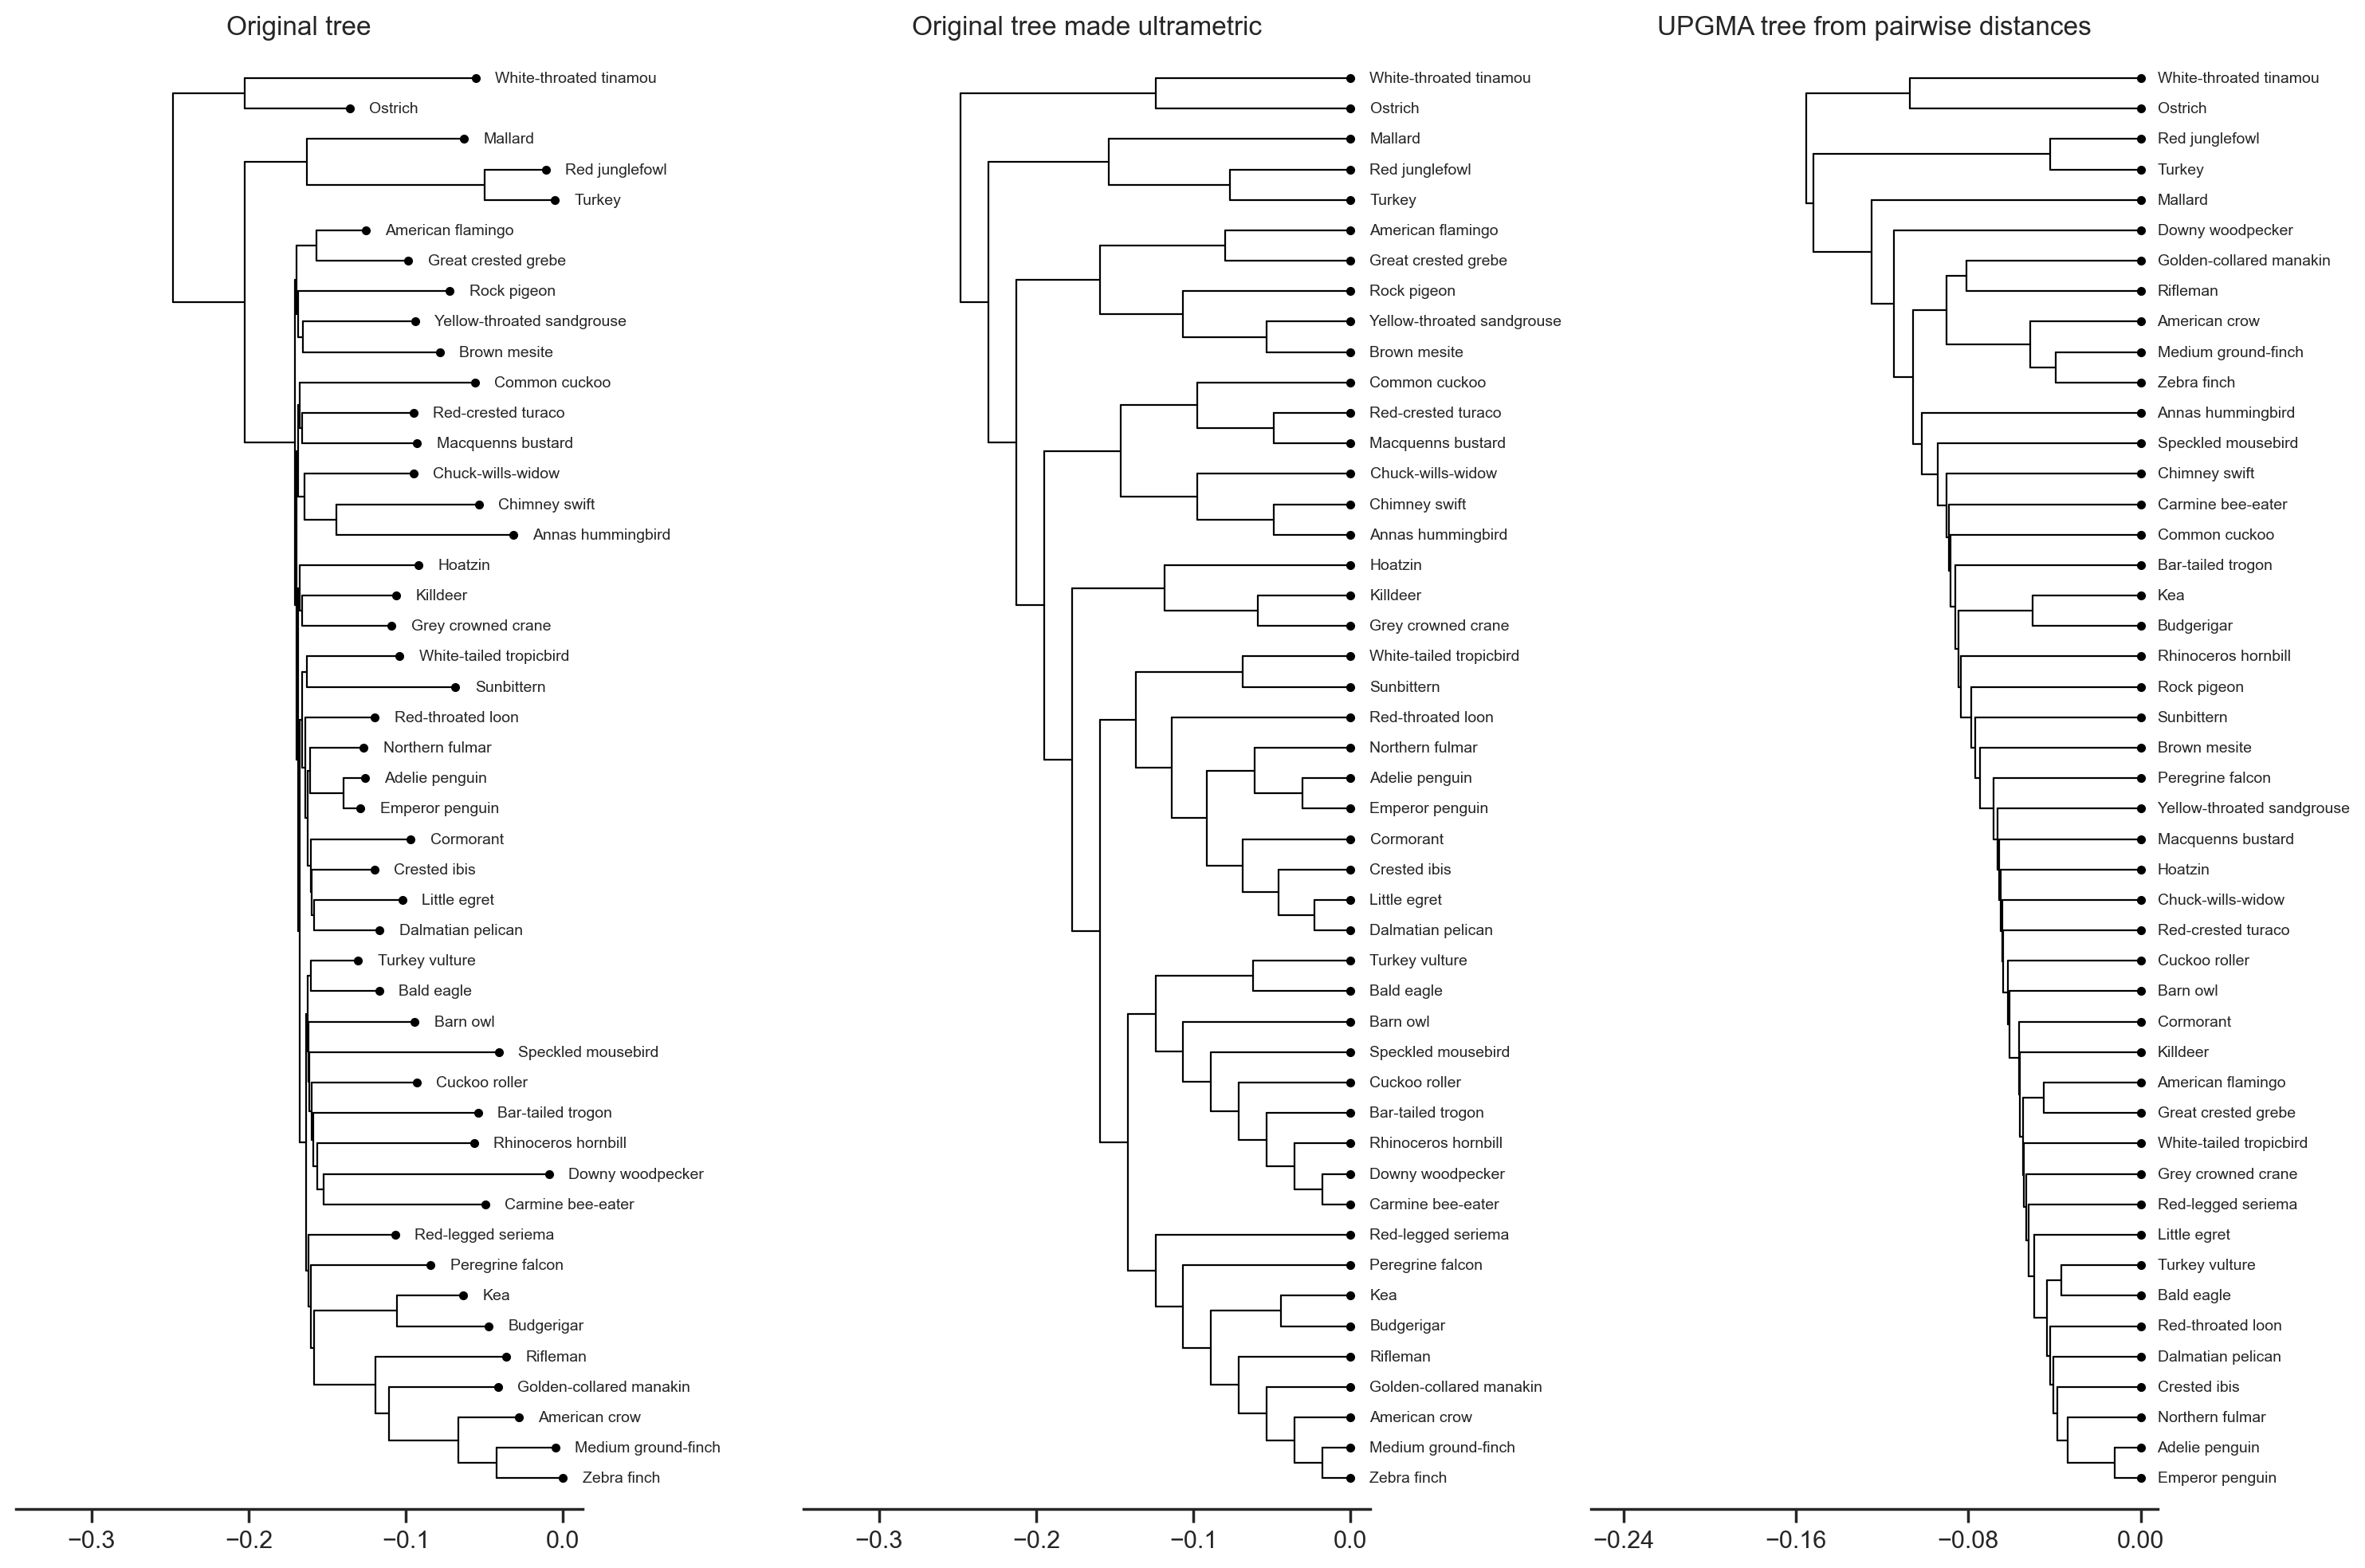

In [11]:
make_comb_tree(tree)
make_comb_tree(ultrametric_tree)
make_comb_tree(upgma_tree)

with sns.axes_style('ticks'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
    leaf_info = plot_tree(tree, ax1, margins=(1, 0.1, 1, 0.1), fontsize=7)
    ax1.set_title('Original tree')
    leaf_info = plot_tree(ultrametric_tree, ax2, margins=(1, 0.1, 1, 0.1), fontsize=7)
    ax2.set_title('Original tree made ultrametric')
    leaf_info = plot_tree(upgma_tree, ax3, margins=(1, 0.1, 1, 0.1), fontsize=7)
    ax3.set_title('UPGMA tree from pairwise distances')
    plt.tight_layout()
    
    plt.savefig(figures_path / 'trees.pdf')

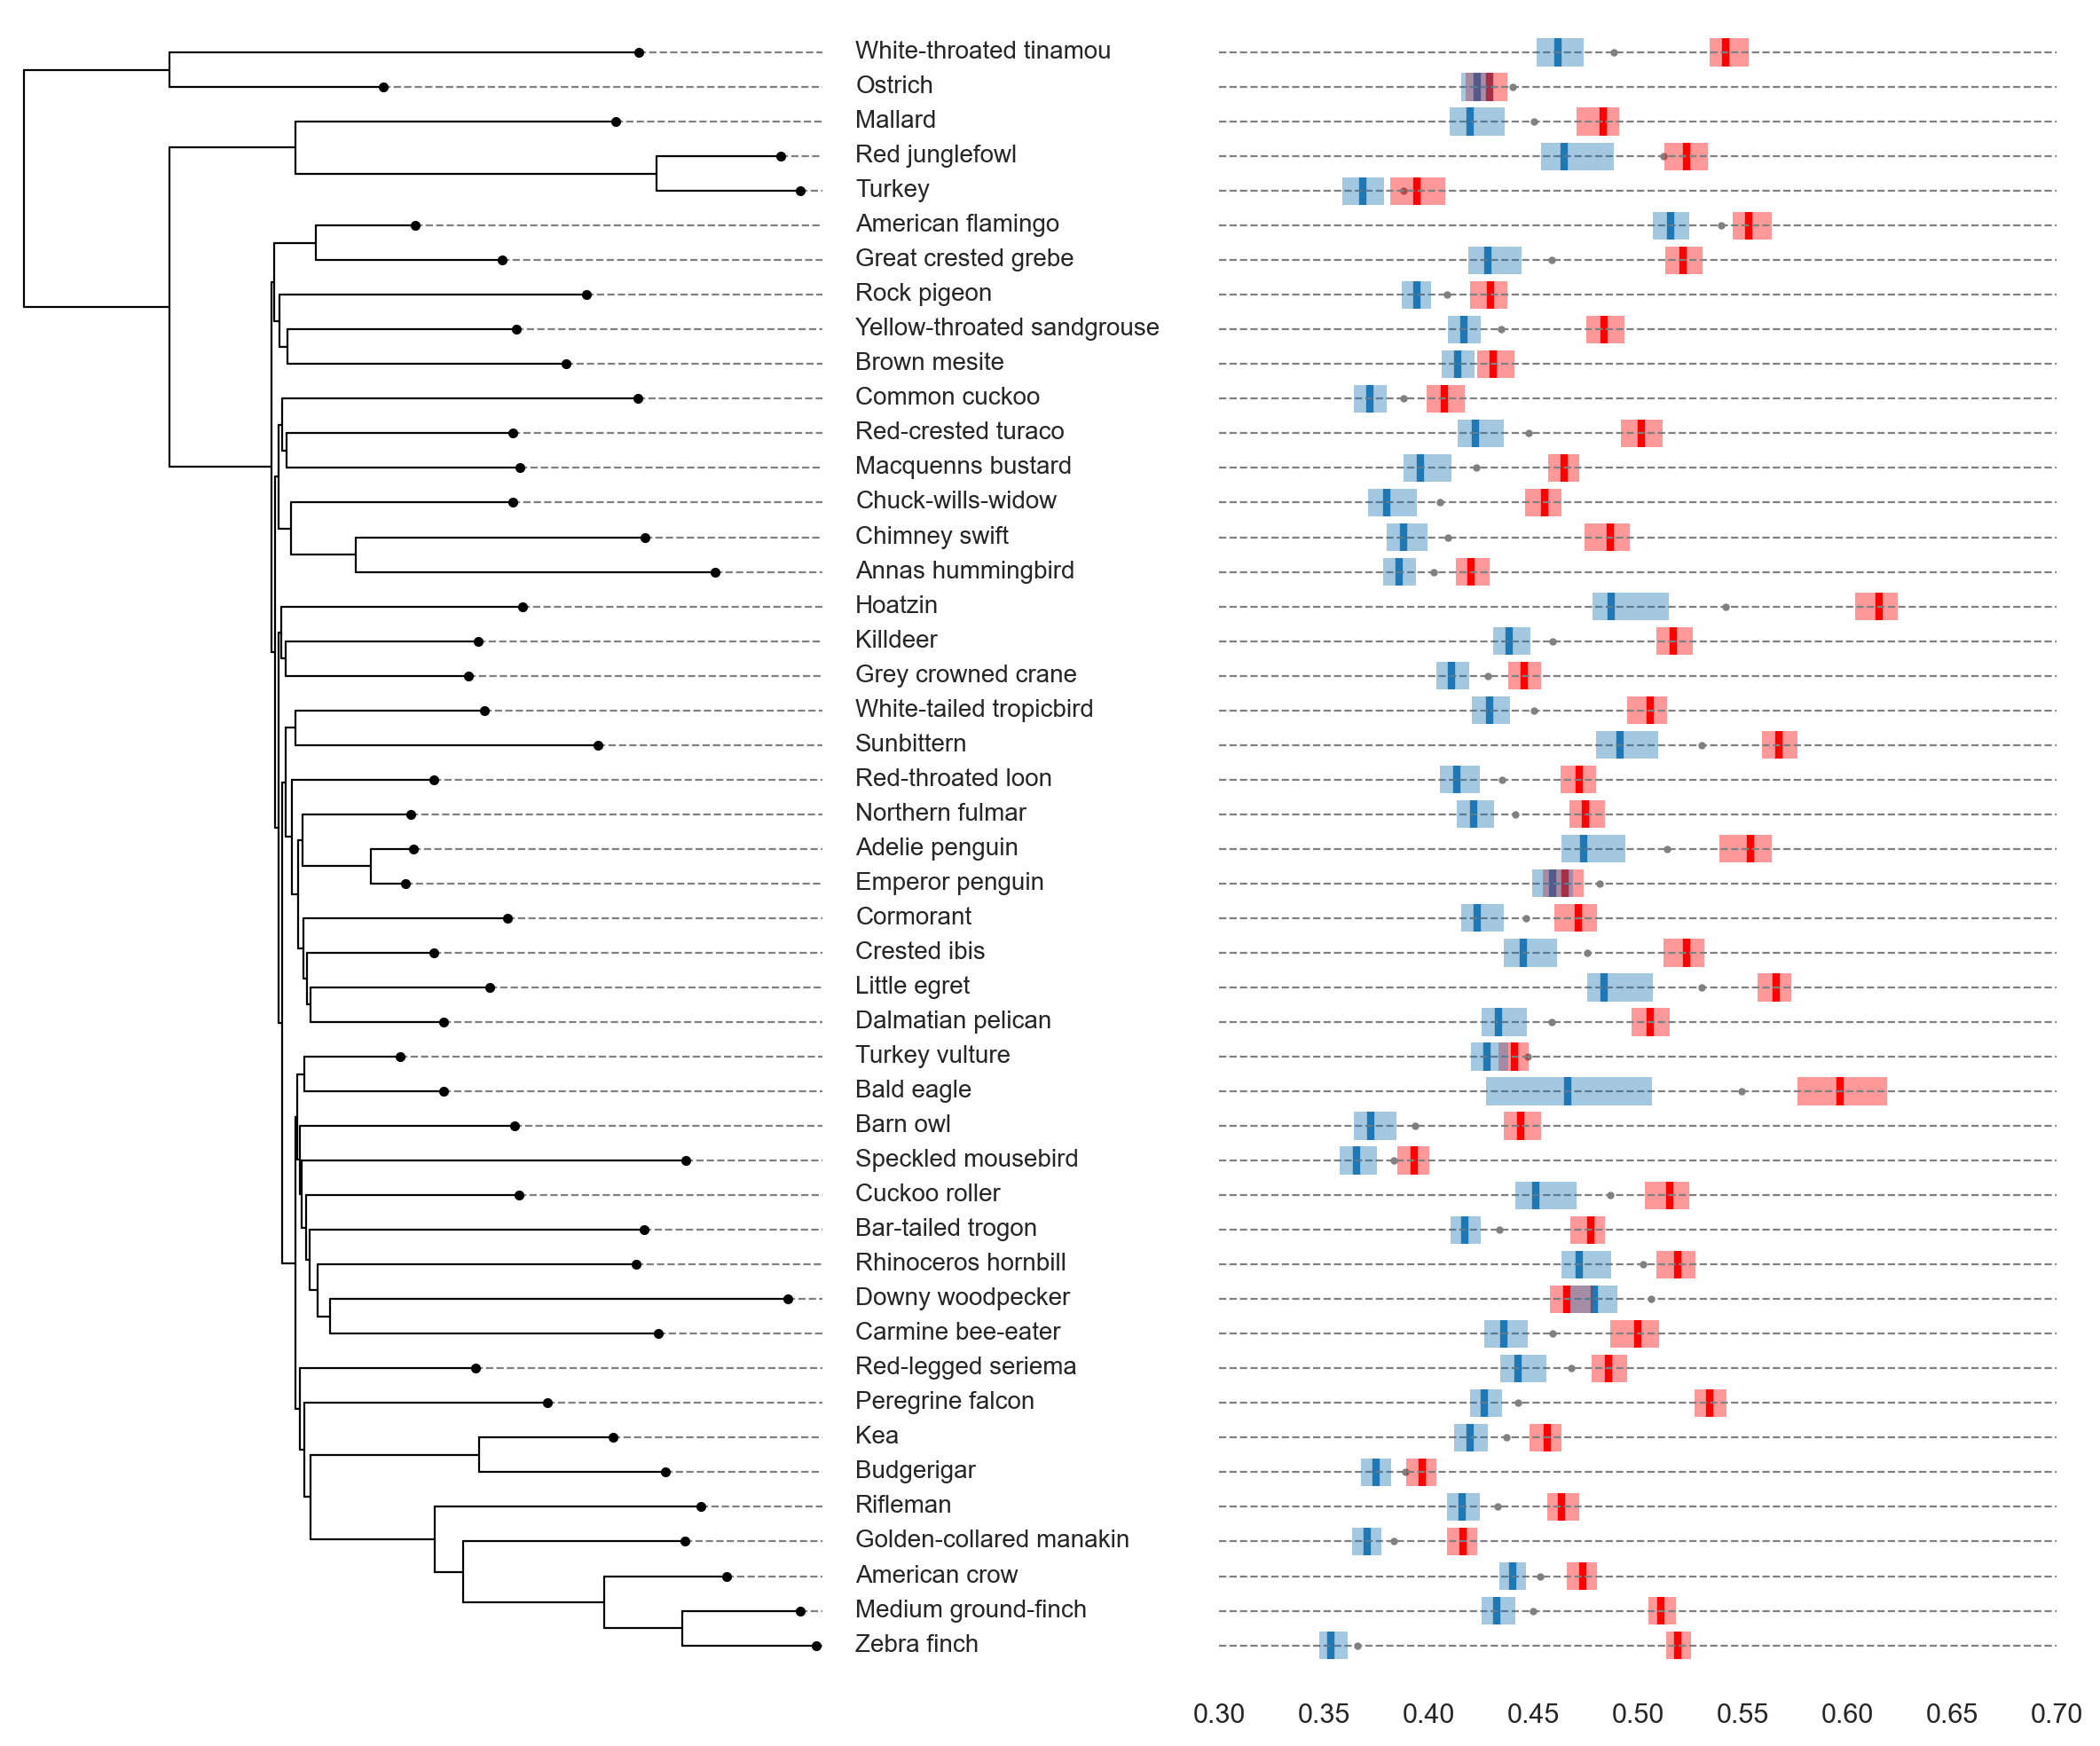

In [12]:
from itertools import groupby
from operator import itemgetter

def jonas_plot(tree, data, figsize=(12, 10)):

    with sns.axes_style('whitegrid'):

        fig = plt.figure(figsize=figsize) 
        gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
        ax0 = plt.subplot(gs[0])
        ax1 = plt.subplot(gs[1])

        leaf_info = plot_tree(tree, ax0, margins=(1, 0.002, 1, 0.002), 
                              fontsize=10, align_labels=True)
        
        with sns.axes_style('white'):
            
            names, x_coords, y_coords = zip(*leaf_info)
            
            for n, x, y in zip(names, x_coords, y_coords):
                
                n = n.split('_', 1)[0]

                tup = next(data.loc[data.species == n].itertuples())

                # ax1.add_patch(Rectangle((tup.fmin, y-0.5),tup.fmax-tup.fmin,1,linewidth=0, edgecolor=None, facecolor='tab:blue', alpha=0.3, zorder=10))
                ax1.add_patch(Rectangle((tup.fmin, y-0.4),tup.fmax-tup.fmin,0.8,linewidth=0, edgecolor=None, facecolor='tab:blue', alpha=0.4, zorder=10))
                # ax1.add_patch(Rectangle((tup.fmin, y-0.5),tup.fmax-tup.fmin,0.5,linewidth=0, edgecolor=None, facecolor='tab:blue', alpha=0.7, zorder=10))

                # ax1.add_line(Line2D((tup.fmid, tup.fmid), (y-0.5, y+0.5), color='darkgrey', solid_capstyle='butt', zorder=1))
                ax1.add_line(Line2D((tup.fmid, tup.fmid), (y-0.4, y+0.4), color='tab:blue', linewidth=3, solid_capstyle='butt', zorder=1))
                # ax1.add_line(Line2D((tup.fmid, tup.fmid), (y-0.5, y), color='darkgrey', solid_capstyle='butt', zorder=1))

                # ax1.add_patch(Rectangle((tup.hmin, y-0.5),tup.hmax-tup.hmin,1,linewidth=0, edgecolor=None, facecolor='tab:red', alpha=0.3, zorder=2))                
                ax1.add_patch(Rectangle((tup.hmin, y-0.4),tup.hmax-tup.hmin,0.8,linewidth=0, edgecolor=None, facecolor='red', alpha=0.4, zorder=2))                
                # ax1.add_patch(Rectangle((tup.hmin, y),tup.hmax-tup.hmin,0.5,linewidth=0, edgecolor=None, facecolor='tab:red', alpha=0.7, zorder=2))                

                # ax1.add_line(Line2D((tup.hmid, tup.hmid), (y-0.5, y+0.5), color='red', solid_capstyle='butt', zorder=3))     
                ax1.add_line(Line2D((tup.hmid, tup.hmid), (y-0.4, y+0.4), color='red', linewidth=3, solid_capstyle='butt', zorder=3))     
                # ax1.add_line(Line2D((tup.hmid, tup.hmid), (y, y+0.5), color='red', solid_capstyle='butt', zorder=3))     
                
                # ax1.add_line(Line2D((tup.fmid*tup.skew, tup.fmid*tup.skew), (y-0.5, y+0.5), color='black', solid_capstyle='butt', linestyle='dotted', zorder=4))
                # ax1.add_line(Line2D((tup.fmid*tup.skew, tup.fmid*tup.skew), (y-0.5, y+0.5), color='black', solid_capstyle='butt', linestyle='dotted', zorder=4))

                ax1.scatter([tup.fmid*tup.skew], [y], color='grey', s=4)
                
            # for y in range(len(leaf_info)+1):
            #     ax1.axhline(y=y-0.5, color='black', linewidth=0.8, zorder=5)   
            for y in range(len(leaf_info)):
                ax1.axhline(y=y, color='grey', linewidth=0.8, linestyle='dashed', zorder=5)               
                
                
            ax1.get_yaxis().set_visible(False)

#             def format_func(value, tick_number):
#                 if value % 100000:
#                     return '' # only ticks for even 100
#                 return "{:.1f}".format((value + start)/1000000)

#             ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

            ax0.grid(False)
            ax0.spines['top'].set_visible(False) 
            ax0.spines['left'].set_visible(False) 
            ax0.spines['right'].set_visible(False) 
            ax0.spines['bottom'].set_visible(False)
            ax0.get_xaxis().set_visible(False)


            ax1.grid(False)
            ax1.spines['top'].set_visible(False) 
            ax1.spines['left'].set_visible(False) 
            ax1.spines['right'].set_visible(False) 
            ax1.spines['bottom'].set_visible(False) 

            ax1.set_xlim(0.3, 0.7)
            ax1.set_ylim(ax0.get_ylim())

            plt.tight_layout()    

        return fig

    
data = pd.read_csv('/home/kmt/Birds/faststorage/data/fig1_data.txt', sep=' ')
#data.head()

fig = jonas_plot(tree, data)
plt.savefig(figures_path / 'tree_with_peak_vs_flank_gcstar.pdf')

**GC star in hotspots and flanks:** Grey:flanks, Red: hotspots, Dashed line: GC star hotspot required for significant difference at hotspot.

Bootstrapping is across hotspots.

"Skewed the number of different substitutions in the hotspots in each of the bootstrapped records, while maintaining the total number of substitutions, until their bias equaled the flanks. Then we stepwise skewed the substitution pattern back until the confidence intervals (again, paired t-test?) of the GC* values no longer overlapped and recorded this as the detection limit."

Get external branch lengths:

In [13]:
records = list()
for node in tree.traverse():
    if node.is_leaf():
        records.append((node.name.split('_')[0], node.up.name, node.get_distance(node.up)))
orig_branch_lengths = pd.DataFrame.from_records(records, columns=['species', 'ancestor', 'branch_length'])

records = list()
for node in ultrametric_tree.traverse():
    if node.is_leaf():
        records.append((node.name.split('_')[0], node.get_distance(node.up)))
ultrametric_branch_lengths = pd.DataFrame.from_records(records, columns=['species', 'ultra_branch_length'])

branch_lengths = (orig_branch_lengths
 .merge(ultrametric_branch_lengths, on='species')
)
branch_lengths.head()

,species,ancestor,branch_length,ultra_branch_length
0,TINGU,Anc02,0.147138,0.124090
1,STRCA,Anc02,0.066905,0.124090
2,ANAPL,Anc04,0.100287,0.153635
3,GALGA,Anc07,0.039056,0.076818
4,MELGA,Anc07,0.044937,0.076818


In [14]:
branch_lengths.to_hdf('../results/branch_lengths.h5', key='df', format='table')

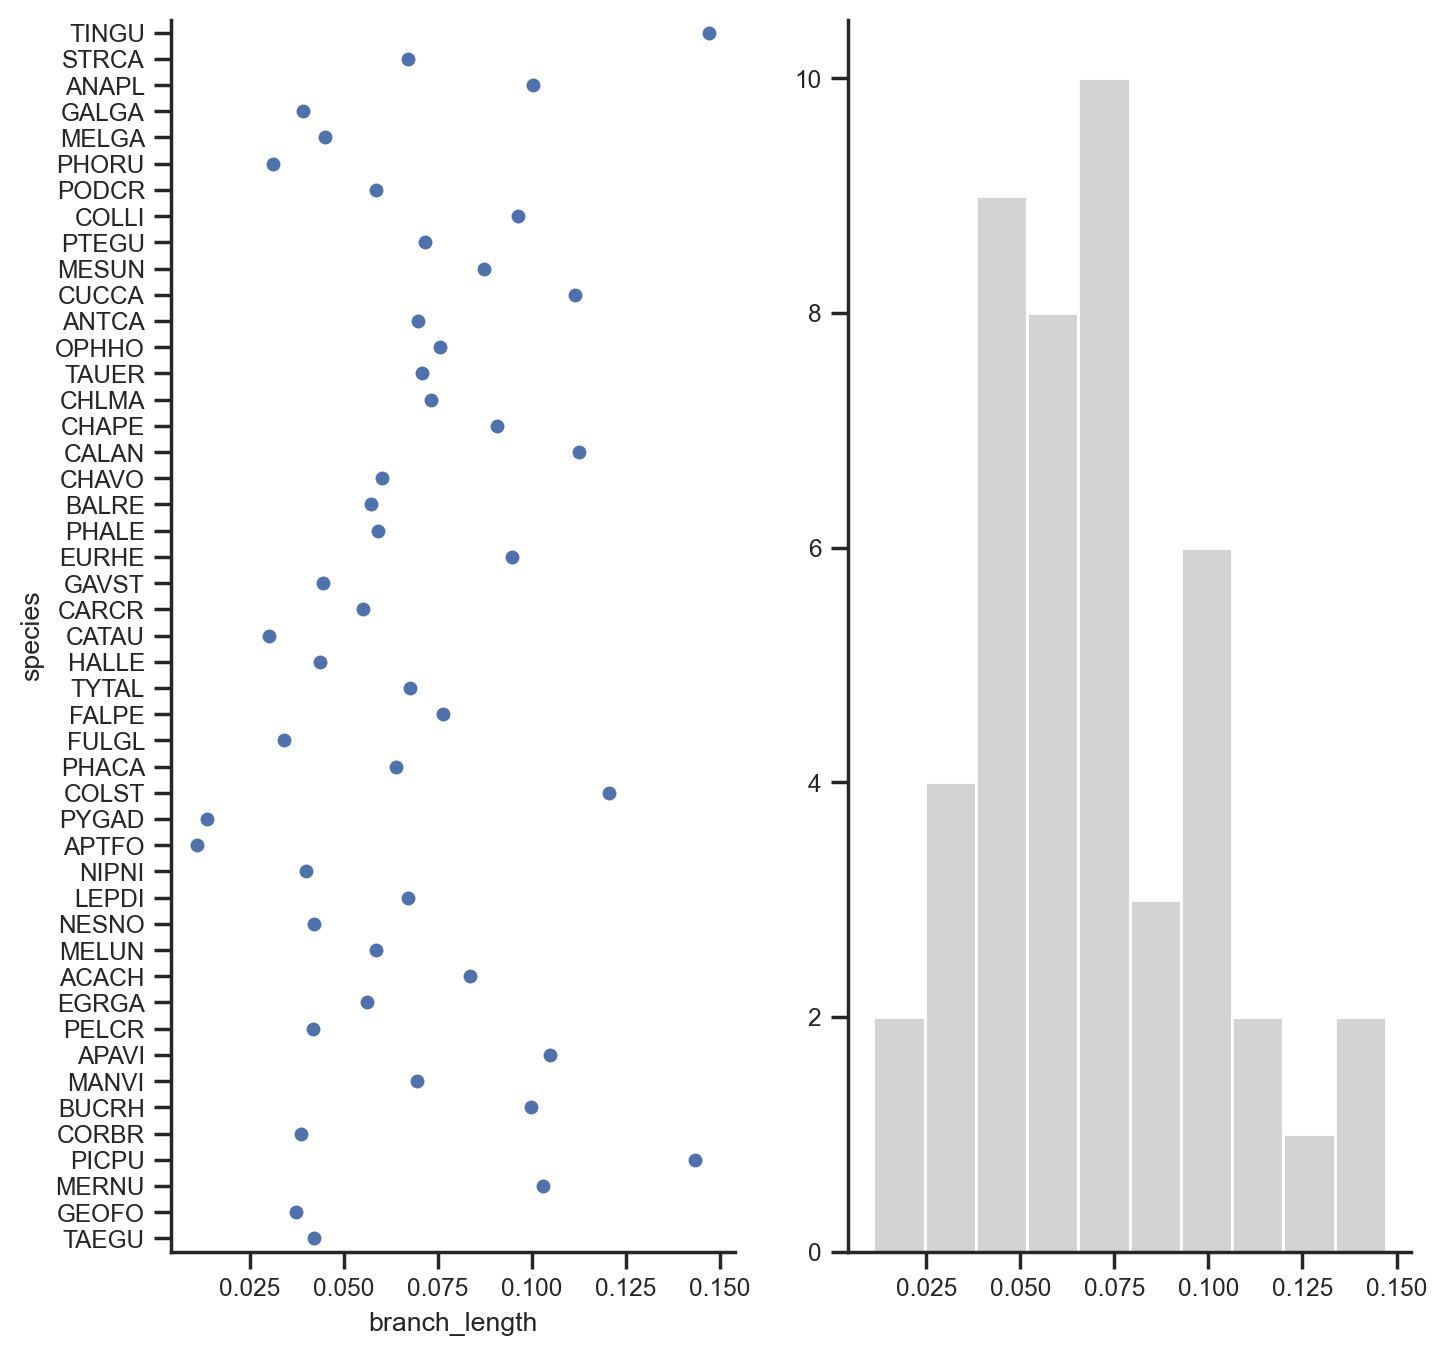

In [15]:
plot_df = branch_lengths.reset_index()#.loc[lambda df: ~df.species.str.startswith('Anc')]

with sns.axes_style("ticks"):
    with sns.plotting_context('notebook', font_scale=0.8):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
        ax = sns.stripplot(y="species", x="branch_length", 
                           data=plot_df,
                           jitter=0, ax=ax1)
        ax = ax2.hist(plot_df.branch_length, color='lightgrey')
        sns.despine()

plt.savefig(figures_path / 'ext_branch_length_distr.pdf')        

# THE BELOW IS NOW REPRESENTED IN NB_PREPARE_DATA_FRAMES.IPYNB

## Load hotspot and CGI data

Hotspot data:

In [16]:
hotspots = pd.read_csv('/project/Birds/faststorage/data/bed/hotspots.bed', names=['chrom', 'start', 'end'], sep='\t')
hotspots['pos'] = (hotspots.start + (hotspots.end - hotspots.start) / 2).round().astype(int)
hotspots['chrom'] = hotspots.chrom.str.replace('chr', '')
hotspots.rename(columns={'stop': 'end'}, inplace=True)
hotspots.head()

,chrom,start,end,pos
0,1,6892116,6896116,6894116
1,1,8803005,8807005,8805005
2,1,9684030,9690030,9687030
3,1,10395061,10399061,10397061
4,1,10500751,10506751,10503751


In [17]:
hotspots.pos.unique().size

2856

CGI data:

In [18]:
cgi = pd.read_csv('/project/Birds/faststorage/data/bed/CGI-taeGut1.txt', sep='\t')
cgi['pos'] = (cgi.start + (cgi.end - cgi.start) / 2).round().astype(int)
cgi['chrom'] = cgi['chr'].str.replace('chr', '')
cgi.head()

,chr,start,end,length,CpGcount,GCcount,pctGC,obsExp,pos,chrom
0,chr1,21810,21940,131,9,83,0.633588,0.685465,21875,1
1,chr1,31020,31136,117,15,82,0.700855,1.054054,31078,1
2,chr1,32772,33056,285,23,202,0.708772,0.642584,32914,1
3,chr1,47794,48027,234,12,130,0.555556,0.668571,47910,1
4,chr1,108367,108549,183,9,93,0.508197,0.772514,108458,1


In [19]:
def optimize_data_frame(df, inplace=False, down_int='integer'):
    # down_int can be 'unsigned'
    
    if inplace:
        converted_df = df
    else:
        converted_df = pd.DataFrame()

    floats_optim = (df
                    .select_dtypes(include=['float'])
                    .apply(pd.to_numeric,downcast='float')
                   )
    converted_df[floats_optim.columns] = floats_optim

    ints_optim = (df
                    .select_dtypes(include=['int'])
                    .apply(pd.to_numeric,downcast=down_int)
                   )
    converted_df[ints_optim.columns] = ints_optim

    for col in df.select_dtypes(include=['object']).columns:
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            converted_df[col] = df[col].astype('category')
        else:
            converted_df[col] = df[col]

    unchanged_cols = df.columns[~df.columns.isin(converted_df.columns)]
    converted_df[unchanged_cols] = df[unchanged_cols]

    # keep columns order
    converted_df = converted_df[df.columns]      
            
    return converted_df

## Read and merge data remapped relative to hotspots

In [20]:
remapped_data_path = data_path / 'composition_cpg_remapped'

All 1kb windows overlapping hotspot center are set to zero distance. For all other windows, the distance is the distane to the closest hotspot center.

In [21]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.hotspot_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
hotspot_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(hotspot_table).to_hdf(results_path / 'hotspot_data.h5', 'df', mode='w', format='table')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
len(hotspot_table.start_prox.unique())

In [ ]:
del hotspot_table
gc.collect()

In [ ]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.cgi_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
cgi_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(cgi_table).to_hdf(results_path / 'cgi_data.h5', 'df', mode='w', format='table')

In [ ]:
del cgi_table
gc.collect()

In [ ]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.promoter_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
promoter_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(promoter_table).to_hdf(results_path / 'promoter_data.h5', 'df', mode='w', format='table')

In [ ]:
del promoter_table
gc.collect()

In [ ]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.tss_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
tss_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(tss_table).to_hdf(results_path / 'tss_data.h5', 'df', mode='w', format='table')

In [ ]:
del tss_table
gc.collect()

In [ ]:
df_list = list()
for path in remapped_data_path.iterdir():
    if path.name.endswith('.tes_relative.txt'):
        df = pd.read_csv(str(path), sep='\t', low_memory=False)
        df_list.append(df)
tes_table = pd.concat(df_list, sort=True).merge(branch_lengths, on=['species', 'ancestor'], how='left')

optimize_data_frame(tes_table).to_hdf(results_path / 'tes_data.h5', 'df', mode='w', format='table')

In [ ]:
del tes_table
gc.collect()

Read hotspot distances relative to CGI, TSS and TES:

In [ ]:
# df_list = list()
# for path in remapped_data_path.iterdir():
#     if path.name.endswith('.hotspot_rel_cgi.txt'):
#         df = pd.read_csv(str(path), sep='\t', low_memory=False)
#         df_list.append(df)
# hotspot_rel_cgi_table = pd.concat(df_list, sort=True)

# optimize_data_frame(hotspot_rel_cgi_table).to_hdf(results_path / 'hotspot_rel_cgi_data.h5', 'df', mode='w', format='table')

In [ ]:
# df_list = list()
# for path in remapped_data_path.iterdir():
#     if path.name.endswith('.hotspot_rel_tss.txt'):
#         df = pd.read_csv(str(path), sep='\t', low_memory=False)
#         df_list.append(df)
# hotspot_rel_tss_table = pd.concat(df_list, sort=True)

# optimize_data_frame(hotspot_rel_cgi_table).to_hdf(results_path / 'hotspot_rel_tss_data.h5', 'df', mode='w', format='table')

In [ ]:
# df_list = list()
# for path in remapped_data_path.iterdir():
#     if path.name.endswith('.hotspot_rel_tes.txt'):
#         df = pd.read_csv(str(path), sep='\t', low_memory=False)
#         df_list.append(df)
# hotspot_rel_tes_table = pd.concat(df_list, sort=True)

# optimize_data_frame(hotspot_rel_tes_table).to_hdf(results_path / 'hotspot_rel_tes_data.h5', 'df', mode='w', format='table')